In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip3 install vncorenlp
!pip install -q emoji

     |████████████████████████████████| 2.7MB 14.3MB/s 
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-cp37-none-any.whl size=2645952 sha256=a4228ac27b934f1b817bd30818c3bbb6a337020399eaf649c12c5bd70a31a176
  Stored in directory: /root/.cache/pip/wheels/09/54/8b/043667de6091d06a381d7745f44174504a9a4a56ecc9380c54
Successfully built vncorenlp
     |████████████████████████████████| 133kB 14.3MB/s 


In [3]:
# !Download VnCoreNLP-1.1.1.jar & its word segmentation component (i.e. RDRSegmenter) 
# !mkdir -p vncorenlp/models/wordsegmenter
# !wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
# !wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
# !wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
# !mv VnCoreNLP-1.1.1.jar vncorenlp/ 
# !mv vi-vocab vncorenlp/models/wordsegmenter/
# !mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

# Pho2vec 300 dim
# !mkdir -p pho2vec
# !wget https://public.vinai.io/word2vec_vi_words_300dims.zip
# !mv word2vec_vi_words_300dims.zip pho2vec/
# !unzip "./pho2vec/word2vec_vi_words_300dims.zip"

# Pho2vec 100 dim
# !mkdir -p pho2vec
# !wget https://public.vinai.io/word2vec_vi_words_100dims.zip 
# !mv word2vec_vi_words_100dims.zip /content/drive/MyDrive/KTDLTT/src/pho2vec
# !unzip -o "/content/drive/MyDrive/KTDLTT/src/pho2vec/word2vec_vi_words_100dims.zip"

# IMPORT LIBRARY AND PATH DATASET

In [4]:
import pandas as pd
import numpy as np
import os
from vncorenlp import VnCoreNLP
import numpy as np
import pickle
import matplotlib.pyplot as plt
import warnings
import logging

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors

from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

# import tensorflow as tf
# # from transformers import TFAutoModel
# from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, LSTM, Bidirectional, GRU, TimeDistributed, Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# from sklearn.metrics import matthews_corrcoef, confusion_matrix
# from sklearn import metrics
# from sklearn.utils import shuffle
# from official.nlp import optimization
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow.train import CheckpointOptions
# from tensorflow.keras.optimizers import Adam

np.random.seed(7)

In [5]:
path_root = '/content/drive/MyDrive/KTDLTT'
path_img = os.path.join(path_root, 'model/VSFC_topic/ML/images')
MODEL_PATH = os.path.join(path_root, 'model/VSFC_topic/ML')
name_model = 'VSFC_topic_'
path_img = os.path.join(path_root, 'model/VSFC_topic/ML/images')

path_VSFC_train_sents = os.path.join(path_root, 'data/UIT-VSFC/train/sents.txt')
path_VSFC_train_sentiments = os.path.join(path_root, 'data/UIT-VSFC/train/sentiments.txt')
path_VSFC_train_topics = os.path.join(path_root, 'data/UIT-VSFC/train/topics.txt')

path_VSFC_test_sents = os.path.join(path_root, 'data/UIT-VSFC/test/sents.txt')
path_VSFC_test_sentiments = os.path.join(path_root, 'data/UIT-VSFC/test/sentiments.txt')
path_VSFC_test_topics = os.path.join(path_root, 'data/UIT-VSFC/test/topics.txt')

path_VSFC_dev_sents = os.path.join(path_root, 'data/UIT-VSFC/dev/sents.txt')
path_VSFC_dev_sentiments = os.path.join(path_root, 'data/UIT-VSFC/dev/sentiments.txt')
path_VSFC_dev_topics = os.path.join(path_root, 'data/UIT-VSFC/dev/topics.txt')
path_VSFC_train_sents = os.path.join(path_root, 'data/UIT-VSFC/train/sents.txt')
path_VSFC_train_sentiments = os.path.join(path_root, 'data/UIT-VSFC/train/sentiments.txt')
path_VSFC_train_topics = os.path.join(path_root, 'data/UIT-VSFC/train/topics.txt')

path_VSFC_test_sents = os.path.join(path_root, 'data/UIT-VSFC/test/sents.txt')
path_VSFC_test_sentiments = os.path.join(path_root, 'data/UIT-VSFC/test/sentiments.txt')
path_VSFC_test_topics = os.path.join(path_root, 'data/UIT-VSFC/test/topics.txt')

path_VSFC_dev_sents = os.path.join(path_root, 'data/UIT-VSFC/dev/sents.txt')
path_VSFC_dev_sentiments = os.path.join(path_root, 'data/UIT-VSFC/dev/sentiments.txt')
path_VSFC_dev_topics = os.path.join(path_root, 'data/UIT-VSFC/dev/topics.txt')

# DATA LOADER AND PREPROCESSING

## Data loader

In [6]:
def read_txt(path):
  with open(path, 'r', encoding='utf-8') as f:
    return [elem.replace('\n', '') for elem in f.readlines()]

df_train = pd.DataFrame(columns=['sents', 'sentiments', 'topics'])
df_train.loc[:, 'sents'] = read_txt(path_VSFC_train_sents)
df_train.loc[:, 'sentiments'] = read_txt(path_VSFC_train_sentiments)
df_train.loc[:, 'topics'] = read_txt(path_VSFC_train_topics)

df_test = pd.DataFrame(columns=['sents', 'sentiments', 'topics'])
df_test.loc[:, 'sents'] = read_txt(path_VSFC_test_sents)
df_test.loc[:, 'sentiments'] = read_txt(path_VSFC_test_sentiments)
df_test.loc[:, 'topics'] = read_txt(path_VSFC_test_topics)

df_dev = pd.DataFrame(columns=['sents', 'sentiments', 'topics'])
df_dev.loc[:, 'sents'] = read_txt(path_VSFC_dev_sents)
df_dev.loc[:, 'sentiments'] = read_txt(path_VSFC_dev_sentiments)
df_dev.loc[:, 'topics'] = read_txt(path_VSFC_dev_topics)


In [7]:
annotator = VnCoreNLP(os.path.join(path_root, "src/vncorenlp/VnCoreNLP-1.1.1.jar"), annotators="wseg", max_heap_size='-Xmx500m') 

def preprocessing(row):
  def tokenizer(row):
    row = annotator.tokenize(row)
    return ' '.join([' '.join(words) for words in row])
  return tokenizer(row)

In [8]:
df_train.loc[:, 'sents'] = df_train.loc[:, 'sents'].apply(preprocessing)
df_test.loc[:, 'sents'] = df_test.loc[:, 'sents'].apply(preprocessing)
df_dev.loc[:, 'sents'] = df_dev.loc[:, 'sents'].apply(preprocessing)

In [9]:
df_train.head(5)

,sents,sentiments,topics
0,slide giáo_trình đầy_đủ .,2,1
1,"nhiệt_tình giảng_dạy , gần_gũi với sinh_viên .",2,0
2,đi học đầy_đủ full điểm chuyên_cần .,0,1
3,chưa áp_dụng công_nghệ_thông_tin và các thiết_...,0,0
4,"thầy giảng bài hay , có nhiều bài_tập ví_dụ ng...",2,0


## Embedding word using PhoW2V

In [10]:
# # Load Pho2wv
# pho2wv = KeyedVectors.load_word2vec_format(os.path.join(path_root, 'src/word2vec_vi_words_100dims.txt'))

In [11]:
MAX_NB_WORDS = 75000
MAX_SEQUENCE_LENGTH = 100

In [12]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(df_train['sents'])
word_index = tokenizer.word_index

In [13]:
def prepare_input(sents, tokenizer, MAX_SEQUENCE_LENGTH=MAX_SEQUENCE_LENGTH):
  sequences = tokenizer.texts_to_sequences(sents)
  sents = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, truncating='post', padding='post')
  return sents

In [14]:
X_train = df_train['sents']
X_test = df_test['sents']
X_dev = df_dev['sents']

In [15]:
X_train_token= prepare_input(X_train, tokenizer)
Y_train = np.array(df_train['topics'].tolist())#

X_dev_token = prepare_input(X_dev, tokenizer)
Y_dev = np.array(df_dev['topics'].tolist())#.reshape(-1,1)

X_test_token = prepare_input(X_test, tokenizer)
Y_test = np.array(df_test['topics'].tolist())#.reshape(-1,1)

In [16]:
# # Create embedding matrix 
# def create_embedding(word_index, embedding_dict, EMBEDDING_DIM=100):
#   embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
#   for word, i in word_index.items():
#     try:
#       embedding_vector = embedding_dict.get_vector(word)
#     except:
#       embedding_vector = None
#     if embedding_vector is not None:
#       if len(embedding_matrix[i]) != len(embedding_vector):
#         # words not found in embedding index will be all-zeros.
#           if len(embedding_matrix[i]) != len(embedding_vector):
#             print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
#                   "into shape", str(len(embedding_vector)), " Please make sure your"
#                                                             " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
#             exit(1)
#           embedding_matrix[i] = embedding_vector
#   return embedding_matrix
# embedding_matrix = create_embedding(word_index, embedding_dict=pho2wv)
# np.save(os.path.join(path_root, 'data/vector/pho2wv_VSFC.npy'), embedding_matrix)

In [17]:
# Load embedding matrix from file npy
embedding_matrix = np.load(os.path.join(path_root, 'data/vector/pho2wv_VSFC.npy'))

In [18]:
def word2vec_sentence(embedding_matrix, data_matrix, MAX_SEQUENCE_LENGTH=MAX_SEQUENCE_LENGTH, EMBEDDING_DIM=300):
    embedding = np.random.random([data_matrix.shape[0], MAX_SEQUENCE_LENGTH, EMBEDDING_DIM])
    for idx, data_vector in enumerate(data_matrix):
      for idy, data_vec in enumerate(data_vector):
          embedding[idx][idy] = embedding_matrix[data_vec]
    return embedding

In [19]:
X_train_input = word2vec_sentence(embedding_matrix, X_train_token)
X_train_input = X_train_input.reshape(X_train_input.shape[0], X_train_input.shape[1] * X_train_input.shape[2])

X_dev_input = word2vec_sentence(embedding_matrix, X_dev_token)
X_dev_input = X_dev_input.reshape(X_dev_input.shape[0], X_dev_input.shape[1] * X_dev_input.shape[2])

X_test_input =  word2vec_sentence(embedding_matrix, X_test_token)
X_test_input = X_test_input.reshape(X_test_input.shape[0], X_test_input.shape[1] * X_test_input.shape[2])

X_train_input.shape

(11426, 30000)

# Fine-tuning with TensorFlow

## Define the model

In [20]:
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn import naive_bayes, svm
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.pipeline import Pipeline

In [21]:
name_model_nvpho = name_model + 'nv_pho'

model = MultinomialNB()
model.fit(X_train_input, Y_train)
print("\n Evaluating Model ... \n")
y_pred = model.predict(X_test_input)
metric_nvpho = classification_report(Y_test, y_pred, output_dict=True) 
print(classification_report(Y_test, y_pred, digits=4))#, target_names=['negative', 'neutral', 'positive']))


 Evaluating Model ... 

              precision    recall  f1-score   support

           0     0.8225    0.3358    0.4769      2290
           1     0.2735    0.4178    0.3306       572
           2     1.0000    0.1793    0.3041       145
           3     0.0849    0.7107    0.1517       159

    accuracy                         0.3623      3166
   macro avg     0.5452    0.4109    0.3158      3166
weighted avg     0.6944    0.3623    0.4262      3166



In [22]:
name_model_nvtfidf = name_model + 'nv_tfidf'

steps=[]
steps.append(('CountVectorizer', CountVectorizer(ngram_range=(1,3),max_df=0.5, min_df=5)))
steps.append(('tfidf', TfidfTransformer(use_idf=False, sublinear_tf = True,norm='l2',smooth_idf=True)))
steps.append(('classifier', naive_bayes.MultinomialNB()))
naive = Pipeline(steps)
naive.fit(X_train, Y_train)
y_pred_nv = naive.predict(X_test)

print("\n Evaluating Model ... \n")
metric_nvtfidf = classification_report(Y_test, y_pred_nv, output_dict=True) 
print(classification_report(Y_test, y_pred_nv, digits=4))#, target_names=['negative', 'neutral', 'positive']))


 Evaluating Model ... 

              precision    recall  f1-score   support

           0     0.8529    0.9598    0.9032      2290
           1     0.6693    0.5839    0.6237       572
           2     0.9767    0.5793    0.7273       145
           3     1.0000    0.0252    0.0491       159

    accuracy                         0.8275      3166
   macro avg     0.8748    0.5371    0.5758      3166
weighted avg     0.8328    0.8275    0.8018      3166



In [23]:
name_model_svm = name_model + 'svm_tfidf'

steps=[]
steps.append(('CountVectorizer', CountVectorizer(ngram_range=(1,3),max_df=0.5, min_df=5)))
steps.append(('tfidf', TfidfTransformer(use_idf=False, sublinear_tf = True,norm='l2',smooth_idf=True)))
steps.append(('classifier', svm.SVC(probability=True, kernel="poly", class_weight="balanced")))
clf = Pipeline(steps)
clf.fit(X_train, Y_train)
y_pred_svm = clf.predict(X_test)

print("\n Evaluating Model ... \n")
metric_svm = classification_report(Y_test, y_pred_svm, output_dict=True) 
print(classification_report(Y_test, y_pred_svm, digits=4))#, target_names=['negative', 'neutral', 'positive']))


 Evaluating Model ... 

              precision    recall  f1-score   support

           0     0.9050    0.9070    0.9060      2290
           1     0.6168    0.7850    0.6908       572
           2     0.9551    0.5862    0.7265       145
           3     0.6111    0.2075    0.3099       159

    accuracy                         0.8351      3166
   macro avg     0.7720    0.6214    0.6583      3166
weighted avg     0.8405    0.8351    0.8290      3166



# Predict on test data

In [24]:
import joblib

def save_model(model, metric, name_model):
  f1 = round(metric['macro avg']['f1-score'], 4)
  name_model_ = name_model + '_' + str(f1).replace('.', '') + '.pkl'
  joblib.dump(model, os.path.join(MODEL_PATH, name_model_))
 
save_model(model, metric_nvpho, name_model_nvpho)
save_model(naive, metric_nvtfidf, name_model_nvtfidf)
save_model(clf, metric_svm, name_model_svm)

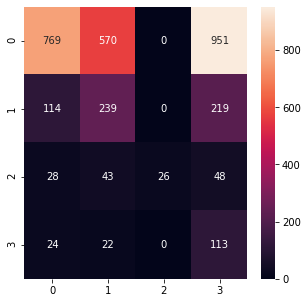

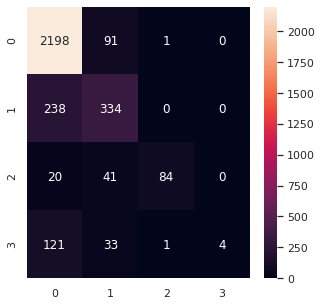

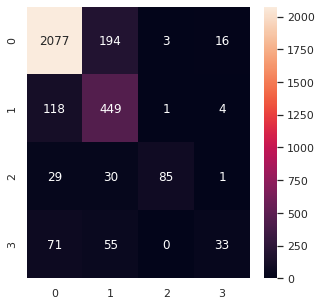

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def _confusion_matrix(Y_test, y_pred, metric, name_model, path_img=path_img):
  f1 = round(metric['macro avg']['f1-score'], 4)
  name_img = 'CM_' + name_model + '_' + str(f1).replace('.', '') + '.png' 
  cf_matrix = confusion_matrix(Y_test, y_pred)
  fig = plt.figure(figsize=(5, 5))
  sns.heatmap(cf_matrix, annot=True, fmt='g')
  sns.set(font_scale=1)
  fig.savefig(os.path.join(path_img, name_img), bbox_inches='tight')
  plt.show()

_confusion_matrix(Y_test, y_pred, metric_nvpho, name_model_nvpho)
_confusion_matrix(Y_test, y_pred_nv, metric_nvtfidf, name_model_nvtfidf)
_confusion_matrix(Y_test, y_pred_svm, metric_svm, name_model_svm)

In [50]:
from sklearn.metrics import f1_score, recall_score, precision_score
print("Naive + Pho2WV:", f1_score(Y_test, y_pred, average='micro'))
print("Naive + Pho2WV:", recall_score(Y_test, y_pred, average='micro'))
print("Naive + Pho2WV:", precision_score(Y_test, y_pred, average='micro'))

print("Naive + TF-IDF:", f1_score(Y_test, y_pred_nv, average='micro'))
print("Naive + TF-IDF:", recall_score(Y_test, y_pred_nv, average='micro'))
print("Naive + TF-IDF:", precision_score(Y_test, y_pred_nv, average='micro'))

print("SVM + TF-IDF:", f1_score(Y_test, y_pred_svm, average='micro'))
print("SVM + TF-IDF:", recall_score(Y_test, y_pred_svm, average='micro'))
print("SVM + TF-IDF:", precision_score(Y_test, y_pred_svm, average='micro'))

Naive + Pho2WV: 0.36228679722046747
Naive + Pho2WV: 0.36228679722046747
Naive + Pho2WV: 0.36228679722046747
Naive + TF-IDF: 0.8275426405559065
Naive + TF-IDF: 0.8275426405559065
Naive + TF-IDF: 0.8275426405559065
SVM + TF-IDF: 0.8351231838281743
SVM + TF-IDF: 0.8351231838281743
SVM + TF-IDF: 0.8351231838281743
